### In this homework assigment, you are required to apply the neural fitted Q-iteration algorithm to a pre-collected dataset for batch (offline) policy optimisation. Please follow the instructions detailed below.

Step 1: Generate an offline dataset. Consider the CartPole example. We will use a sub-optimal policy for data generation. Specifically, consider the following deterministic policy $\pi_b$ that returns 0 (left) if the pole angle is negative and 1 otherwise. To allow exploration, we set the behavior policy to be a mixture of $\pi_b$ and a uniform random policy. Specifically, the agent will follow the uniform random policy or $\pi_b$ with equal probability. We simulate 100 episodes under this policy. This yields the offline dataset.

Step 2: Fitted Q-iteration. We will apply the neural fitted Q-iteration (FQI) algorithm to this offline data to compute an optimal policy with three different choices of $\gamma$, corresponding to 0.95, 0.99 and 1. Please refer to Page 43 of Lecture 5 for the pseudocode of FQI in batch settings. We repeat the Q-iteration 20 times, e.g., apply supervised learning algorithms 20 times to learn the optimal Q-function. The initial Q-estimator can be set to a zero function. Each iteration yields a Q-estimator, based on which we can derive an estimated optimal policy. In total, we obtain 20 $\times$ 3 (3 choices of $\gamma$) different policies.

* To combine FQI with neural networks, we consider using the [MLPregressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) function. We can use the default neural network architecture (no need to specify no. of layers or no. of hidden nodes per layer). We may set the maximum number of iterations to 500.

* In this example, we only have two actions (either pushing the cart to the left or to the right). As such, it would be better to use the second type of value function approximators on Page 11 of Lecture 5 (e.g., for each action, use a separate model for the value). The last type of approximators would be preferred in settings where we have a large action space.

* The TD target depends on whether the current state is a terminal state or not. For a nonterminal state, the TD target is constructed as in the lecture slide. For a terminal state, the TD target is equal to the immediate reward.

Step 3: Policy evaluation. For each of the computed 60 policies, we use the Monte Carlo method to evaluate the expected return under this policy, by generating 1000 episodes. Finally, plot all the returns in a single figure and comment on the results.

In [1]:
# Neccesary packages for the implementation
from sklearn.neural_network import MLPRegressor
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Imports enviroment CartPole from Gymnasium
env = gym.make('CartPole-v1')

From seminar code, some description of the environment:

#### Action
Two discrete actions: $a=0$ indicates pushing cart to the left and $a=1$ pushes the cart to the right.  The amount the velocity reduced or increased does not only depends on the direction you are moving but also on the angle the pole is pointing. 

#### Reward
 Reward is +1 for every step taken, including the termination step.
 
#### Observation
There are 4 observations returned by the environment after each action taken by an agent:
- Cart position:  a number between `-4.8` and `4.8`
- Cart velocity: a number between `-inf`and `inf`
- Pole angle: an angle between -24&deg; and 24&deg; 
-  Pole velocity at tip: a number between `-inf`and `inf`

#### Termination
- Cart position is smaller or greater than `-2.4` or `2.4`
- Pole Angle is smaller or greater than -12&deg; or 12&deg;
- Episode length is longer than 200

Note that we have a continuous state variable of the form $S_t = (x, v, \theta, \phi)$. Having a continuous state space make tabular methods intractable in terms of space memory. For this reason it is ideal to use a function to estimate the value o state-action value functions.

The action space is very simple and makes the problem easier.

### Step 1
Generate an offline dataset. Consider the CartPole example. We will use a sub-optimal policy for data generation. Specifically, consider the following deterministic policy $\pi_b$ that returns 0 (left) if the pole angle is negative and 1 otherwise. To allow exploration, we set the behavior policy to be a mixture of $\pi_b$ and a uniform random policy. Specifically, the agent will follow the uniform random policy or $\pi_b$ with equal probability. We simulate 100 episodes under this policy. This yields the offline dataset.

In [2]:
# Policy \pi_b
def pi_b(angle):
    if angle < 0:
        return 0
    else:
        return 1

$D$ is where I will save all the observations for the training of the NNs (offline batch).

Consider the following:
- It is a dictionary that contains a key (for each episode) and the value is a list with all the data from the episode.

- It saves observations  of the environment in the form $(S_t, a_t, S_{t+1}, \text{done})$.

- The reward for each step is 1 and therefore it is not needed to save it.

- With probability 0.5 follows policy $\pi_b$ and with the rest 0.5 takes random action.

In [3]:
def gen_data(episodes):
    D = {}
    for i in range(episodes):
        D[i] = []
        S = env.reset()[0]
        a = pi_b(S[2])
        done = False
        while not done:
            # Takes a step
            next_S, r, done, info, _ = env.step(a)
            
            # Saves observations  of the environment in the form (S_t, a_t, S_{t+1}, done)
            D[i].append([S, a, next_S, done])
            
            # Toss a coin: follow deterministic policy \pi_b or random action is selected
            if np.random.random() <= 0.5:
                # Action from policy \pi_b
                a = pi_b(next_S[2])
            else:
                # Random action
                a = env.action_space.sample()
            S = next_S
    return D

In [4]:
episodes = 100
D = gen_data(episodes)

### Step 2
Fitted Q-iteration. We will apply the neural fitted Q-iteration (FQI) algorithm to this offline data to compute an optimal policy with three different choices of $\gamma$, corresponding to 0.95, 0.99 and 1. Please refer to Page 43 of Lecture 5 for the pseudocode of FQI in batch settings. We repeat the Q-iteration 20 times, e.g., apply supervised learning algorithms 20 times to learn the optimal Q-function. The initial Q-estimator can be set to a zero function. Each iteration yields a Q-estimator, based on which we can derive an estimated optimal policy. In total, we obtain 20 $\times$ 3 (3 choices of $\gamma$) different policies.

* To combine FQI with neural networks, we consider using the [MLPregressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) function. We can use the default neural network architecture (no need to specify no. of layers or no. of hidden nodes per layer). We may set the maximum number of iterations to 500.

* In this example, we only have two actions (either pushing the cart to the left or to the right). As such, it would be better to use the second type of value function approximators on Page 11 of Lecture 5 (e.g., for each action, use a separate model for the value). The last type of approximators would be preferred in settings where we have a large action space.

* The TD target depends on whether the current state is a terminal state or not. For a nonterminal state, the TD target is constructed as in the lecture slide. For a terminal state, the TD target is equal to the immediate reward.


#### Initialisation
Here I initialise all the data needed. I will work with two Q-function estimators (one for each action) defined by NNs.

In [5]:
def initialisation():
    # This are the inputs of the NNs of the form (S_t) for each action
    input0 = [D[ep][step][0] for ep in range(episodes) for step in range(len(D[ep])) if D[ep][step][1] == 0]
    input1 = [D[ep][step][0] for ep in range(episodes) for step in range(len(D[ep])) if D[ep][step][1] == 1]

    # Tuples of the next state
    next_S0 = [D[ep][step][2] for ep in range(episodes) for step in range(len(D[ep])) if D[ep][step][1] == 0]
    next_S1 = [D[ep][step][2] for ep in range(episodes) for step in range(len(D[ep])) if D[ep][step][1] == 1]

    # Target (the initial target is set to be 1, it will include the future in the next iterations)
    target0 = [1 for ep in range(episodes) for step in range(len(D[ep])) if D[ep][step][1] == 0]
    target1 = [1 for ep in range(episodes) for step in range(len(D[ep])) if D[ep][step][1] == 1]

    # Wheter next state is terminal or not
    done0 = [D[ep][step][3] for ep in range(episodes) for step in range(len(D[ep])) if D[ep][step][1] == 0]
    done1 = [D[ep][step][3] for ep in range(episodes) for step in range(len(D[ep])) if D[ep][step][1] == 1]

    # Training of 2 NNs using input and target
    regr0 = MLPRegressor(random_state=1, max_iter=500).fit(input0, target0)
    regr1 = MLPRegressor(random_state=1, max_iter=500).fit(input1, target1)

    # Prediction using 2 NNs just trained
    Q0_hat = regr0.predict(next_S0)
    Q1_hat = regr1.predict(next_S1)

    return input0, input1, Q0_hat, Q1_hat, next_S0, next_S1, done0, done1

#### Useful functions

In [6]:
# Calculates the TD target 
def calc_target(gamma, Q_hat, done):
    y = []
    for i in range(len(Q_hat)):
        # If terminal state, target is 1
        if done[i]:
            y.append(1)
        # If non terminal state, target computed as in lecture slides
        else:
            y.append(1 + gamma * Q_hat[i])
    return y

# Receives the regressors of the NN and a state to estimate its qfunction
# Returns the action with the highest estimated Qvalue 
def approximated_optimal_policy(regr0, regr1, S):
    S = S.reshape(1, -1)
    Q0_final = regr0.predict(S)
    Q1_final = regr1.predict(S)
    
    if Q0_final > Q1_final:
        return 0
    else:
        return 1

#### Neural Fitted Q-iteration algorithm

The goal is to estimate the value of being in state $S_t$ and taking action $a_t$.

- $\hat{Q}_0(s_t)$ is the estimator of being in state $s_t$ and taking action 0.

- $\hat{Q}_1(s_t)$ is the estimator of being in state $s_t$ and taking action 1.

The estimators are two NNs (one for each action) where the target is 

$$\text{target} = r_t + \gamma  \hat{Q}_a(s_{t+1})$$

or simply 1 if the next state is terminal.

The input is a tuple that receives the state 

$$S_t = (x, v, \theta, \phi)$$.

This way each neural network receives a state and outputs the estimated Q-function of each action by minimising the following expression:
$$\sum_t [R_t + \gamma \max \hat{Q}_a(S_{t+1}), - Q_a(S_t)]^2$$
for each action $A_t \in \{0,1\}$.

Here, the policy is given by:
$$\pi = \arg\max_{a}\hat{Q}_a(s)$$
but recall that $\hat{Q}_a(s)$ is given by a NN, therefore the only thing we need to compute the policy are the actual regressors (or weights) for the NN. 

Furthermore, since the whole idea of approximating the state-action value function is to avoid tabular methods due to the large (or continuous) state space, I only save the weights of the NN in each iteration and this is the only thing needed to compute the policy that maps an action. In other words, each policy is given by a set of regressors of a NN.

In [7]:
def NFQ_it(gamma, Q_iterations):
    input0, input1, Q0_hat, Q1_hat, next_S0, next_S1, done0, done1 = initialisation()
    regressors = {}
    for i in range(Q_iterations):
        Q0_est = Q0_hat 
        Q1_est = Q1_hat

        # If terminal state, target should be 1
        target0 = calc_target(gamma, Q0_est, done0)
        target1 = calc_target(gamma, Q1_est, done1)

        # Trainig of the NNs with TD target and input are states
        regr0 = MLPRegressor(random_state=1, max_iter=500).fit(input0, target0)
        regr1 = MLPRegressor(random_state=1, max_iter=500).fit(input1, target1)

        # Prediction of Q_value functions for each action (0, 1)
        Q0_hat = regr0.predict(next_S0)
        Q1_hat = regr1.predict(next_S1)
         
        # Saves the regressors of the NN trained
        regressors[i] = [regr0, regr1]
        
    return regressors


gammas = [0.95, 0.99, 1]
Q_iterations = 20
regressors = {}
for gamma in gammas:
    print(gamma)
    regressors[gamma] = NFQ_it(gamma, Q_iterations)

0.95


C:\Users\Germa\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Germa\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Germa\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Germa\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Germa\anaconda3\lib\site-packages\sklearn\neural_network\_multi

0.99


C:\Users\Germa\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Germa\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Germa\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Germa\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Germa\anaconda3\lib\site-packages\sklearn\neural_network\_multi

1


C:\Users\Germa\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Germa\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Germa\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Germa\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Germa\anaconda3\lib\site-packages\sklearn\neural_network\_multi

### Step 3
Policy evaluation. For each of the computed 60 policies, we use the Monte Carlo method to evaluate the expected return under this policy, by generating 1000 episodes. Finally, plot all the returns in a single figure and comment on the results.

This code simply evaluates 1000 episodes for each of the 60 policies and computes the average over the 1000 episodes. This way the estimation of the expected reward for a given policy is the average.

In [8]:
N_episodes = 1000
rewards = {}
for gamma in gammas:
    print(gamma)
    for it in range(Q_iterations):
        cum_rewards = 0
        for ep in range(N_episodes): 
            N_counter = 0
            rewards[gamma, it] = 0
            S = env.reset()[0]
            a = approximated_optimal_policy(regressors[gamma][it][0], 
                                            regressors[gamma][it][1], 
                                            S)
            done = False
            
            while not done and N_counter < 500:
                N_counter += 1
                next_S, r, done, info, _ = env.step(a)
                cum_rewards += r
                a = approximated_optimal_policy(regressors[gamma][it][0], 
                                                regressors[gamma][it][1], 
                                                next_S)
                
                S = next_S
        rewards[gamma, it] = cum_rewards / N_episodes

0.95
0.99
1


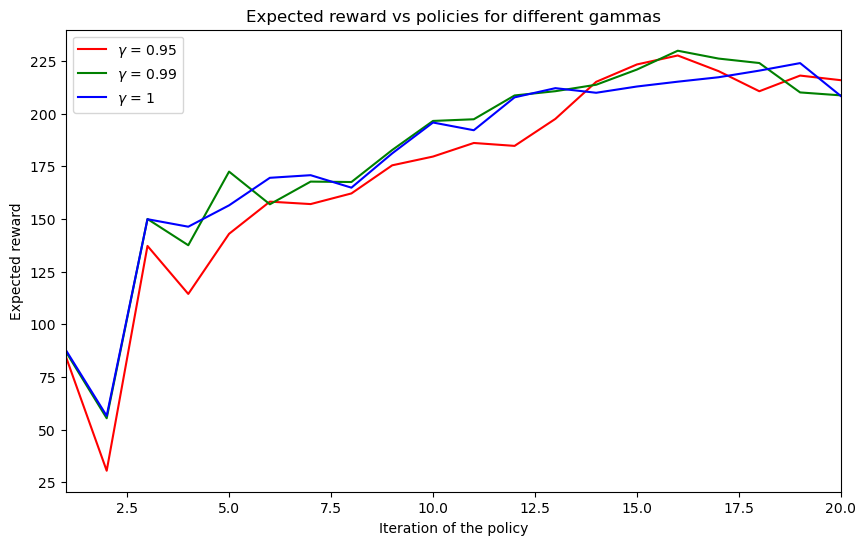

In [17]:
iterations = {}
for gamma in gammas:
    iterations[gamma] = []
    for key, value in rewards.items():
        if key[0] == gamma:
            iterations[gamma].append((key[1], value))

plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b']
for i, gamma in enumerate(gammas):
    x = [item[0] +1 for item in iterations[gamma]]
    y = [item[1] for item in iterations[gamma]]
    plt.plot(x, y, label=f'$\gamma$ = {gamma}', color=colors[i])

plt.xlim([1, 20])
plt.xlabel('Iteration of the policy')
plt.ylabel('Expected reward')
plt.title('Expected reward vs policies for different gammas')
plt.legend()
plt.show()

From the plot above, one can notice that throughout the iterations the policy improves (and shows an increasing trend) till a given point where it start to become kind of constant. The best policy is after around the 15th iteration of the algorithm for $\gamma=0.99$, but between them they are very similar anyway. It is interesting to note that the algorithm improves throughout iterations and the agent is actually learning as expected. Therefore, the best policy one can consider is using $\gamma = 0.99$ after around 15 iterations of the algorithm.

Finally, one need to take into account that each episode has a limit of 500 steps and this policies get to half of the value. Meaning that in some cases the agent learn so good to balance the pool that it would balance it forever if this termination condition is not imposed.

## References
Riedmiller, M. (2005). Neural Fitted Q Iteration – First Experiences with a Data Efficient Neural Reinforcement Learning Method. In: Gama, J., Camacho, R., Brazdil, P.B., Jorge, A.M., Torgo, L. (eds) Machine Learning: ECML 2005. ECML 2005. Lecture Notes in Computer Science(), vol 3720. Springer, Berlin, Heidelberg. https://doi.org/10.1007/11564096_32.

Damien Ernst, Pierre Geurts, and Louis Wehenkel. 2005. Tree-Based Batch Mode Reinforcement Learning. J. Mach. Learn. Res. 6 (12/1/2005), 503–556.

Lecture slides ST455